<a href="https://colab.research.google.com/github/manvirkaur84/manvirkaur/blob/main/docs/ml-concepts/207_ML_MSBA/SBACaseLogit%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
%pip install dmba

In [138]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, recall_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
import math
from scipy.stats import chi2


DATA = Path('/content/sample_data/')

#***Section A:*** ⤵
####Fit a logistic regression model to reproduce parameter (coefficient) estimates (up to 4 decimals) in Tables 7(a), 8, 9 of this article using the SBA case data SBAcase.11.13.17.csv by using (1) sklearn LogisticRegression() liblinear solver and (2) sklearn LogisticRegression() Default Solver 'lbfgs'.
____________

#Using sklearn LogisticRegression() liblinear solver

##Table 7(a).1

In [110]:
sba_df = pd.read_csv(DATA / 'SBAcase.11.13.17.csv')

# TARGET VARIABLE - 'Default' is our dummy variable derived from "MIS_Status"
# The value for “Default” = 1 if MIS_Status = CHGOFF, and “Default” = 0 if MIS_Status = PIF
sba_df['Default'] = np.where(sba_df['MIS_Status'] == 'CHGOFF', 1, 0)
sba_df.drop(columns=['MIS_Status'], inplace=True)

# Training data only
train = sba_df[sba_df['Selected'] == 1].copy()

# Predictors for Table 7(a)
predictors = ['New', 'RealEstate', 'DisbursementGross', 'Portion', 'Recession']
X_train = train[predictors].copy()
y_train = train['Default']

scaler = StandardScaler()
X_train['DisbursementGross'] = scaler.fit_transform(X_train[['DisbursementGross']])

# Fit logistic regression (liblinear, very large C to mimic no penalty)
logit_reg = LogisticRegression(solver='liblinear', penalty='l2', C=1e42, max_iter=1000)
logit_reg.fit(X_train, y_train)


print(f"intercept  {logit_reg.intercept_[0]:.4f}")
coef_df = pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=predictors)
print(coef_df.round(4))   # round to 4 decimals
print()


intercept  1.2703
                    coeff
New               -0.0772
RealEstate        -2.0329
DisbursementGross -0.1160
Portion           -2.8297
Recession          0.4971



##Table 8.1

In [111]:
sba_df = pd.read_csv(DATA / 'SBAcase.11.13.17.csv')

# TARGET VARIABLE - 'Default' is our dummy variable derived from "MIS_Status"
# The value for “Default” = 1 if MIS_Status = CHGOFF, and “Default” = 0 if MIS_Status = PIF
sba_df['Default'] = np.where(sba_df['MIS_Status'] == 'CHGOFF', 1, 0)
sba_df.drop(columns=['MIS_Status'], inplace=True)

# Training data only
train = sba_df[sba_df['Selected'] == 1].copy()

# Predictors for Table 8
predictors = ['RealEstate', 'Portion', 'Recession']
X_train = train[predictors]
y_train = train['Default']

# validation/test set (Selected = 0)
valid_X = sba_df[sba_df['Selected'] == 0][predictors]
valid_y = sba_df[sba_df['Selected'] == 0]['Default']

# Fit logistic regression (liblinear, very large C to mimic no penalty)
logit_reg = LogisticRegression(solver='liblinear', penalty='l2', C=1e42, max_iter=1000)
logit_reg.fit(X_train, y_train)


print(f"intercept  {logit_reg.intercept_[0]:.4f}")
coef_df = pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=predictors)
print(coef_df.round(4))   # round to 4 decimals
print()

intercept  1.3930
             coeff
RealEstate -2.1282
Portion    -2.9874
Recession   0.5041



##Table 9.1

In [112]:
#code from Dicussion Assignment #1  - sklearn LogisticRegression() liblinear solver
#Table 9

predictions = logit_reg.predict(valid_X)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
classificationSummary(valid_y, predictions_nominal)

Confusion Matrix (Accuracy 0.6784)

       Prediction
Actual   0   1
     0 682  14
     1 324  31


# Using sklearn LogisticRegression() Default Solver **'lbfgs'**

##Table 7(a).2


In [113]:
sba_df = pd.read_csv(DATA / 'SBAcase.11.13.17.csv')

# TARGET VARIABLE - 'Default' is our dummy variable derived from "MIS_Status"
# The value for “Default” = 1 if MIS_Status = CHGOFF, and “Default” = 0 if MIS_Status = PIF
sba_df['Default'] = np.where(sba_df['MIS_Status'] == 'CHGOFF', 1, 0)
sba_df.drop(columns=['MIS_Status'], inplace=True)

# Training data only
train = sba_df[sba_df['Selected'] == 1].copy()

# Predictors for Table 7(a)
predictors = ['New', 'RealEstate', 'DisbursementGross', 'Portion', 'Recession']
X_train = train[predictors].copy()
y_train = train['Default']

# validation/test set (Selected = 0)
valid_X = sba_df[sba_df['Selected'] == 0][predictors]
valid_y = sba_df[sba_df['Selected'] == 0]['Default']

logit_reg_default = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
logit_reg_default.fit(X_train, y_train)

print(f"intercept  {logit_reg_default.intercept_[0]:.4f}")
coef_df = pd.DataFrame({'coeff': logit_reg_default.coef_[0]}, index=predictors)
print(coef_df.round(4))   # round to 4 decimals
print()


intercept  0.6887
                    coeff
New               -0.2054
RealEstate        -2.6111
DisbursementGross -0.0000
Portion           -1.5922
Recession          0.3239



##Table 8.2

In [114]:
sba_df = pd.read_csv(DATA / 'SBAcase.11.13.17.csv')

# TARGET VARIABLE - 'Default' is our dummy variable derived from "MIS_Status"
# The value for “Default” = 1 if MIS_Status = CHGOFF, and “Default” = 0 if MIS_Status = PIF
sba_df['Default'] = np.where(sba_df['MIS_Status'] == 'CHGOFF', 1, 0)
sba_df.drop(columns=['MIS_Status'], inplace=True)

# Training data only
train = sba_df[sba_df['Selected'] == 1].copy()

# Predictors for Table 7(a)
predictors = ['RealEstate', 'Portion', 'Recession']
X_train = train[predictors].copy()
y_train = train['Default']

# validation/test set (Selected = 0)
valid_X = sba_df[sba_df['Selected'] == 0][predictors]
valid_y = sba_df[sba_df['Selected'] == 0]['Default']

logit_reg_default = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
logit_reg_default.fit(X_train, y_train)

print(f"intercept  {logit_reg_default.intercept_[0]:.4f}")
coef_df = pd.DataFrame({'coeff': logit_reg_default.coef_[0]}, index=predictors)
print(coef_df.round(4))   # round to 4 decimals
print()


intercept  1.4010
             coeff
RealEstate -2.1301
Portion    -3.0000
Recession   0.5002



##Table 9.2

In [115]:
#code from Dicussion Assignment #1  - sklearn LogisticRegression() liblinear solver
#Table 9

predictions = logit_reg.predict(valid_X)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
classificationSummary(valid_y, predictions_nominal)

Confusion Matrix (Accuracy 0.6784)

       Prediction
Actual   0   1
     0 682  14
     1 324  31


#***Section B*** ⤵
####Refer to Table 8 of the article. Write the estimated equation that associates the outcome variable (i.e., default or not) with predictors RealEstate, Portion, and Recession, in three formats:
* The logit as a function of the predictors
* The odds as a function of the predictors
* The probability as a function of the predictors
------


Estimated Equation(s):
* B0 = Intercept
* B2 = RealEstate
* B3 = Portion
* B4 = Recession

p = P(Default = 1 | RealEstate, Portion, Recession)

1) Logit Function = ln(1/(1-p)) = B0 + B1X1 + B2X2 + B3X3
* ln(1/(1-p)) = 1.3931 + (-2.1821 * X1) + (-2.9875 * X2) + (0.5041 * X3)

2) Odds Function = p/(1-p) = e^logit
* e^[1.3931 + (-2.1821 * X1) + (-2.9875 * X2) + (0.5041 * X3)]

3) Probability Function = p = (odds/1+odds)
* [(e^[1.3931 + (-2.1821 * X1) + (-2.9875 * X2) + (0.5041 * X3))/(1+e^[1.3931 + (-2.1821 * X1) + (-2.9875 * X2) + (0.5041 * X3))]

#***Section C*** ⤵
#####Explain why risk indicators in Table 8 were selected using p-values in Table 7(a).
------


Risk indicators in Table 8 were selected using p-values from Table 7(a) to make the model simpler and reliable. Table 7(a) had 5 variables, but DisembursementGross and New were dropped beacaue their p-values were greater than 0.05, which made them statistically insignificant causing them to have no serious effect on the data. The remaining variables all had p-values less than 0.05 and were selected.

#***Section D*** ⤵
##### Interpret parameter (coefficient) estimates of the model in Table 8 with a focus on the odds of default. Answer the following questions by interpreting parameter estimates of the model in Table 8 and specifying odds and probabilities of default for these risk indicators.
------


**Notes**


1. If B1 < 0, an increase in X1 is associated with a decrease in the odds of belonging to class 1, whereas a positive value of B1 is associated with an increase in the odds.
2. Odds Ratio = e^B1 (math.exp(B1))
3. If OR < 1: odds are lower (1-OR)*100
4. If OR > 1: odds are higher (OR-1)*100

***References:***
* Machine Learning for Business Analytics - Concepts, Applications, and Technique in Python
* [Odds Ratio Interpretation](https://www.statology.org/interpret-odds-ratio-less-than-1/)

##(i) Is a loan backed by real estate more likely or less likely to default (by how much)? Explain using parameter estimates.

In [116]:

math.exp(-2.1301)

0.11882541071719105

RealEstate < 0 which means an increase in X1 is associated with a decrease in the odds of a loan likely to default. (OR) Odds Ratio = 0.119 and < 1 which means the loan backed by real estate is less likely to default while holding all other variables constant.

##(ii) Is a loan active during recession more likely or less likely to default (by how much)? Explain using parameter estimates.

In [117]:
math.exp(0.5002)

1.649051047930892

Recession > 0 and is associated with an increase in the odds of a loan likely to default. OR = 1.65 and > 1 which means the loan active during recession is more likely to default while holding all other variables constant.

##(iii) How much does the portion of a loan guaranteed by SBA increase or decrease the likelihood of default? Explain using parameter estimates.

In [118]:
math.exp(-3.000)

0.049787068367863944

RealEstate < 0 which means an increase in X1 is associated with a decrease in the odds of a loan likely to default. (OR) Odds Ratio = 0.119 and < 1 which means the loan backed by real estate is less likely to default while holding all other variables constant.

#***Section E*** ⤵
#####Produce the gains and lift charts for the validation data. Report the lift on the first decile and interpret it.
------


Confusion Matrix (Accuracy 0.6784)

       Prediction
Actual   0   1
     0 682  14
     1 324  31


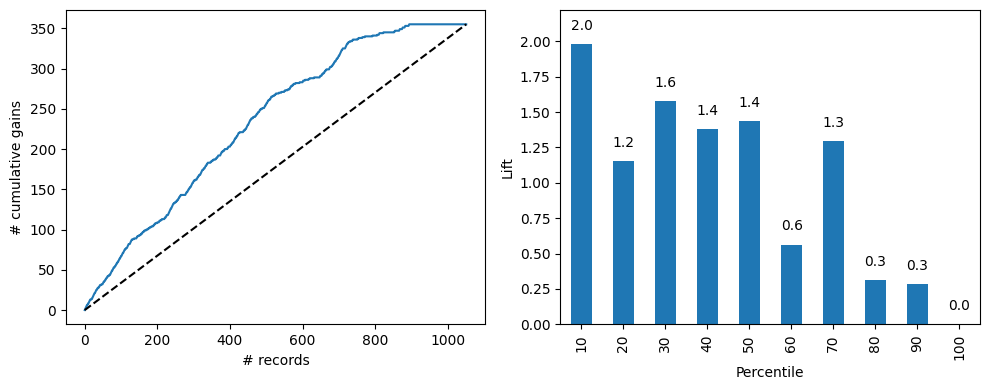

In [119]:
logit_reg_pred = logit_reg_default.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_reg_default.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(valid_y, predictions_nominal)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(full_result.actual, ax=axes[0])
liftChart(full_result.actual, title=False, ax=axes[1])

plt.tight_layout()
plt.show()

Records are grouped into 10 deciles, and for each decile, the chart prsents the ratio of model gains to naive benchmark gains, which is called lift; hence, decile-lift chart.

The lift on the first decile (top 10%) is 2.0. This means that in the top 10%, there will be 2x as many loan defaults (those who fail to pay the loan) compared to the overall default rate. So, there will be more higher risk that the loans will default in the top 10%.

#***Section F*** ⤵
#####For the California-based example, the final model with the risk indicators in Table 8 is used to estimate the probability of default for the two loan applications. Use Python to predict the probability of default for Realty (Loan 1) and SV Consulting (Loan 2). Applying the decision rules and cutoff probability of 0.5 from Section 4.3, how should these two loans be classified as, lower risk (approve) or higher risk (deny)?
------


In [120]:
predictions = logit_reg_default.predict(valid_X)   # pass your feature matrix here

#0 = Lower Risk
#1 = Higher Risk
cutoff = 0.50
predictions_nominal = [0 if p <= cutoff else 1 for p in predictions]
print(predictions_nominal)

classificationSummary(valid_y, predictions_nominal, class_names=['Lower Risk','Higher Risk'])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In Section 4.3, the following rules are adopted after cutoff probabiloty of 0.5 and decision rules are applied:

1. Classify the loan application into the lower risk categoryand approve the loan when estimated probability of default <= 0.5
2. Classify the loan application into the higher risk categoryand deny the loan when estimated probability of default > 0.5

#***Section G*** ⤵
#####Using the validation data and a cutoff probability of 0.5, calculate the following metrics:
* recall (sensitivity)
* specificity,
* precision,
* F1-score

##### Show how each metric is calculated using the formulas and report their values.

a = 682, b = 14, c = 324, *d* = 31
------


In [121]:
y_true = np.asarray(valid_y).astype(int)
y_pred = np.asarray(predictions_nominal).astype(int)

TP = np.sum((y_pred == 1) & (y_true == 1))  # predicted 1 & actual 1
TN = np.sum((y_pred == 0) & (y_true == 0))  # predicted 0 & actual 0
FP = np.sum((y_pred == 1) & (y_true == 0))  # predicted 1 but actual 0
FN = np.sum((y_pred == 0) & (y_true == 1))  # predicted 0 but actual 1

##Recall(Sensitivity)


% of class 1 correctly classified: d/(c+d) = 8.7%

31/(324+31) = 0.087

*Used where classificatin of positives are high priority

In [122]:
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
print(f"  Recall (Sensitivity): {recall:.3f}")

  Recall (Sensitivity): 0.087


##Specificity

% of class 0 correctly classified: a/(a+b) = 98%

682/(682+14) = 0.98

*Used where classification of negatives are high priority

In [123]:
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
print(f"  Specificity:{specificity:.3f}")


  Specificity:0.980


##Precision


% of predicted class 1 that are actually "class 1's": d/(b+d) = 69%

31/(14+31) = 0.69

*Used where false positives are particularly costly or undesirable

In [124]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
print(f"  Precision:{precision:.3f}")


  Precision:0.689


##F1-score


Combine precision and recall values into a single measure, giving them equal weights.

F1 = (2 * precision * recall)/(precision + recall)

F1 = (2 * 0.69 * 0.087)/(0.69 + 0.087) = 0.15 = 16%

In [125]:
F1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
print(f"  F1-score:             {F1:.3f}")

  F1-score:             0.155


#***Section H*** ⤵
#####Review sklearn - [Tuning the decision threshold for class prediction](https://scikit-learn.org/stable/modules/classification_threshold.html). The default cutoff value of 0.5 is used in conjunction with the probability of default. Compute the threshold that should be used if we want to make a classification based on the odds of default, and the threshold for the corresponding logit.
------


In [142]:
scorer = make_scorer(f1_score, pos_label=1)

tuned = TunedThresholdClassifierCV(
    estimator=logit_reg_default,      # your already-fitted LogisticRegression
    scoring=scorer
)

# Tune on your validation set
tuned.fit(valid_X, valid_y)

# Single chosen threshold (probability), and its odds/logit equivalents
p_thr = tuned.best_threshold_
odds_thr  = p_thr / (1 - p_thr)
logit_thr = np.log(odds_thr)

print(f"Best probability threshold:  {p_thr:.4f}")
print(f"Equivalent odds threshold:   {odds_thr:.4f}")
print(f"Equivalent logit threshold:  {logit_thr:.4f}")


Best probability threshold:  0.3894
Equivalent odds threshold:   0.6379
Equivalent logit threshold:  -0.4496


#***Section I*** ⤵
#####A bank will use this logit model to predict the probability of default of the loan and make a classification decision by comparing the predicted probability of default with the cutoff probability. There are two correct decisions: true positive, true negative. There are two wrong decisions: false positive, false negative. The default 0.50 may not be a good cutoff probability.​ We studied in Chapter 5 to make a decision by maximizing classification accuracy, maximizing sensitivity subject to minimum level of specificity, minimizing false positives subject to maximum false negative rate, minimizing expected cost of misclassification (need to specify costs). Suppose a bank needs to evaluate loan application for a $1,000,000 loan with an annual interest rate of 10%. What is a cutoff probability that you can justify as being reasonable to help the bank make a decision whether or not to approve the loan?
------


#***Section J*** ⤵
#####Analyze the trade-off between different classification metrics. The current model uses a cutoff probability of 0.5. However, a bank's primary concern isn't just accuracy; it's managing risk and profit.
------


##Explain the trade-off between recall and precision. Why might a bank prioritize one over the other in different economic situations (e.g., during a recession vs. an economic boom)?

The sensitivity (recall) of a classifier is its ability to detect the important class members correctly. It is also called the Timer Positive Rate (TPR). It is the % of positive members that are correctly classified.

Precision is often considered in tandem with recall. The precision of a classifier is its ability to correctly detect only the important(positive) class members. It is the % of correctly classified positive members among all those classified as positive.

While precision is a measure of exactness, recall is a measure of completeness. Depending on the different economic situations (e.g., during a recession vs. an economic boom), precision may be more important than recall or vice versa.

For instance, when a bank is working on credit card fraud detection, the positive class represents all the fraudulent cases. For these cases, we would want the recall close to 1 since we want to find all transactions that are truly fraudulent. In this situation, we can accept low precision (mistakenly classifying non-fraudulent transactions as fradulent) if the cost of this type of misclassification is not too high.

##Explain the trade-off between recall and specificity. Consider the costs of misclassification. When a loan is misclassified as "higher risk" (false positive), the bank loses a potential profit from interest. When a loan is misclassified as "lower risk" (false negative), the bank risks losing the entire loan amount. Given these different costs, which metric would a bank generally want to maximize, and why? Justify your answer using the concepts of Type I and Type II errors.

Recall and specificity both move in opposite directions. Recall of a classifier is its ability to detect the important class members correctly and the specificity of a classifier is its ability to rule out the negative members correctly. We can plot these measures against the cutoff value in order to find a cutoff value that balances these measures. Lowering the cutoff flags more high-risk loans, but also denies more good ones. Raising the cutoff flags fewer high-risk loans, but misses more bad ones, causing greater loss.

Given these different costs, a bank would generally want to maximize profit. Type I error is a false positive, where a good loan is denied and leads to lost profit. Type II error is a false negative where a bad loan is approved and leads to credit loss. Type II error hurts more. The best model is not the one with the highest accuracy at a given rate; rather, it is the one that maximizes profit and minimizes misclassification cost.This often means choosing a lower cutoff to increase recall for the default class (fewer Type II errors), while keeping specificity above an acceptable floor.

#***Section K*** ⤵
#####When a “higher risk - more likely to default” loan is misclassified as a “lower risk - more likely to pay in full” loan, the misclassification cost is much higher than when a “lower risk - more likely to pay in full” loan is misclassified as a “higher risk - more likely to default”, e.g., 5 times as high. To minimize the expected cost of misclassification, determine the appropriate cutoff value for classification.
------


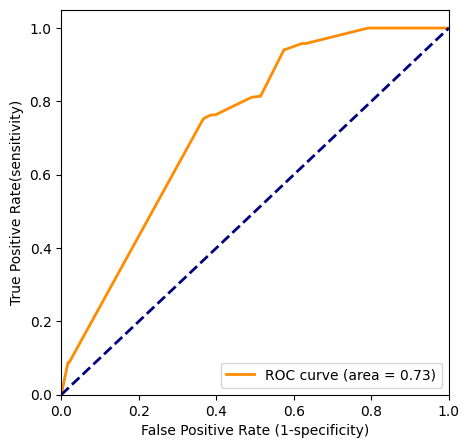

Optimal cutoff (minimize expected cost): 0.2407


In [127]:
y_score = logit_reg_default.predict_proba(valid_X)[:, 1]
fpr, tpr, thr = roc_curve(valid_y, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate(sensitivity)')
ax.legend(loc="lower right")
plt.show()

# Costs: FN is 5 × FP (5 times as high)
C_FP, C_FN = 1, 5

# Minimize expected misclassification cost
pi = np.mean(valid_y)
cost = C_FN * pi * (1 - tpr) + C_FP * (1 - pi) * fpr
best_thr = thr[np.argmin(cost)]

print(f"Optimal cutoff (minimize expected cost): {best_thr:.4f}")

#***Section L*** ⤵
#####Using the logit model fitted in Part (a) with the sklearn's LogisticRegression () that reproduced parameter estimates (4 decimals) in Table 8, determine the optimal cutoff probability that maximizes recall while ensuring that precision is at least 0.8.
------


##Explain the trade-off you are balancing with this constraint. Why might a bank prioritize this specific combination of metrics?

A bank might prioritize this specific combination of metrics because with 80% precision, it will flag more high-risk loans and catch more defaulters. When recall is maximized and precision is subject to >= 0.80, false alarms are kept low while true defaulters are caught.

However, in my work, no threshold reaches precision 0.80 on the validation set; the best feasible operating point at precision 0.7 yields a cutoff of 0.5631 and a recall of 0.0873. Both are provided below.


##Provide the Python code used to find this cutoff. Report the final cut-off probability and the corresponding recall and precision values.

In [128]:
#Precision at 0.80

#Generate precision-recall data points
precision, recall, thresholds = precision_recall_curve(valid_y, y_score)

#Find the optimal threshold
min_precision = 0.80
optimal_recall = 0.0
optimal_threshold = 0.0

#Find the highest recall with at least 80% precision (finding the max)
for p, r, t in zip(precision, recall, thresholds):
    if p >= min_precision and r > optimal_recall:
        optimal_recall = r
        optimal_threshold = t

print(f"Optimal Cutoff Probability: {optimal_threshold:.4f}")
print(f"Recall at this threshold: {optimal_recall:.4f}")
print(f"Corresponding Precision: {min_precision}")

Optimal Cutoff Probability: 0.0000
Recall at this threshold: 0.0000
Corresponding Precision: 0.8


In [129]:
#Precision at 0.70

#Generate precision-recall data points
precision, recall, thresholds = precision_recall_curve(valid_y, y_score)

#Find the optimal threshold
min_precision = 0.70
optimal_recall = 0.0
optimal_threshold = 0.0

#Find the highest recall with at least 80% precision (finding the max)
for p, r, t in zip(precision, recall, thresholds):
    if p >= min_precision and r > optimal_recall:
        optimal_recall = r
        optimal_threshold = t

print(f"Optimal Cutoff Probability: {optimal_threshold:.4f}")
print(f"Recall at this threshold: {optimal_recall:.4f}")
print(f"Corresponding Precision: {min_precision}")

Optimal Cutoff Probability: 0.5631
Recall at this threshold: 0.0873
Corresponding Precision: 0.7
